In [1]:
import cv2 , random
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from PIL import Image
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [2]:
model = load_model("FINALMODELS/captchasolve.h5")
label_encoder = joblib.load('trained_label_encoder.pkl')
model_test = YOLO("yolo_model2/best.pt")


image number : 493

image 1/1 c:\Users\User\Desktop\Captcha\captchas\captcha_493.png: 128x640 8 characterss, 20.9ms
Speed: 6.5ms preprocess, 20.9ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 640)


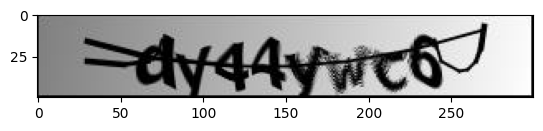

Number of letters extracted: 8
1/1 [==============================] - 0s 13ms/step
dy44ywc6


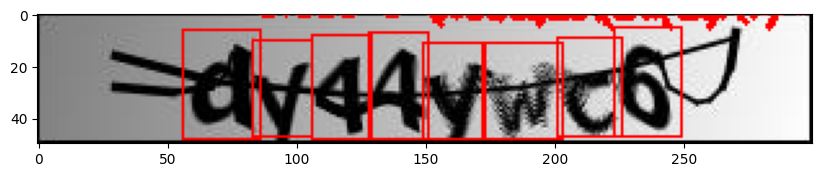

In [4]:

def show_image(image):
    plt.close()
    plt.imshow(image , cmap='gray')
    plt.show()


rendnum = random.choice(range(30 , 500))
image_path_test = f"captchas/captcha_{rendnum}.png"
print(f"image number : {rendnum}")
image_test = cv2.imread(image_path_test)
results_test = model_test(image_path_test)
detections_test = results_test[0].boxes
detections_test = sorted(detections_test, key=lambda box: box.xyxy[0][0])

def check_letter_tarakom(pic):
    _, pic = cv2.threshold(pic, 127, 255, cv2.THRESH_BINARY)
    s = 90 - (np.sum(pic , axis=0 , keepdims=True) / 255)
    total = len(s[0])
    howmanyblack = 0
    for i in s[0]:
        if np.sum(i) >= 175:
            howmanyblack += 1
    if total - howmanyblack <= 22:
        return True
    else:
        return False

letters_test = []

last_one = []

howmany = 0 
for box in detections_test:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    if last_one != []:
        if int(x1) - last_one[0] > 10:
            letter_crop = image_test[y1:y2, x1:x2] 
            resized_letter = cv2.resize(letter_crop, (32, 52)) 
            resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY) 
            if howmany == 8:
                if check_letter_tarakom(letter_crop) == True:
                        _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                        letters_test.append(resized_letter)
            elif howmany <= 7:
                    _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                    letters_test.append(resized_letter)
            last_one = [int(x1), int(y1), int(x2), int(y2)]
            howmany += 1
    else:
        letter_crop = image_test[y1:y2, x1:x2] 
        resized_letter = cv2.resize(letter_crop, (32, 52)) 
        resized_letter = cv2.cvtColor(resized_letter, cv2.COLOR_BGR2GRAY)
        if check_letter_tarakom(letter_crop) == True:
                _, binarized = cv2.threshold(resized_letter, 128, 255, cv2.THRESH_BINARY)
                letters_test.append(resized_letter)
        last_one = [int(x1), int(y1), int(x2), int(y2)]
        howmany += 1

show_image(image_test)
print(f"Number of letters extracted: {len(letters_test)}")

allpredicted = []

for i in range(0,len(letters_test)):
    sample_image = np.array(letters_test[i])  
    sample_image = sample_image.reshape(1, 52, 32, 1) 
    predicted_label = model.predict(sample_image)
    predicted_class = label_encoder.inverse_transform([predicted_label.argmax()])
    allpredicted.append(predicted_class[0])
captcha_result = "".join(allpredicted)
print(captcha_result)
#-------------------
last_one = []

def add_to_dataset(add:False , allpredicted , lab:str):
    global image_test
    tosave = image_test.copy()
    if add == True:
        if f"samples/{lab}.png" not in os.listdir("samples"):
            cv2.imwrite(f"samples/{lab}.png" , tosave)
            print("saved")
        else:
            print("existed")
for_show = image_test.copy()

howmany = 0 
for box in detections_test:
    try:
        x1, y1, x2, y2 = box.xyxy[0].tolist() 
        if last_one != []:
            if  int(x1) - last_one[0] >= 11:
                confidence = box.conf[0] 
                cls = int(box.cls[0]) 
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                ff = for_show[y1:y2, x1:x2]
                if howmany == 8:
                    if check_letter_tarakom(ff) == True:
                        cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
                elif howmany <= 7:
                    cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
                
                labelr = f"Class {cls} ({confidence:.2f})"
                cv2.putText(for_show, labelr, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
                last_one = [int(x1), int(y1), int(x2), int(y2)]
                howmany +=1
        else:
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            ff = for_show[y1:y2, x1:x2]
            if check_letter_tarakom(ff) == True:
                cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
            last_one = [int(x1), int(y1), int(x2), int(y2)]
            howmany +=1
    except Exception as e:
        print(e)
        x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
        ff = for_show[y1:y2, x1:x2]
        cv2.rectangle(for_show, (int(x1), int(y1)), (int(x2), int(y2)), color=(255, 0, 0), thickness=1)
        last_one = [int(x1), int(y1), int(x2), int(y2)]
        howmany += 1

plt.figure(figsize=(10, 10))  
plt.imshow(for_show)
plt.show()